In [1]:
import sys
sys.path.insert(0, '..')

In [2]:
# Basic imports
import jax.numpy as np
import jax.random as jr
import jax.scipy as jsp
import jax
import numpy

jax.config.update("jax_enable_x64", True)

# Optimisation imports
import zodiax as zdx
import optax

# dLux imports
import dLux as dl
import dLux.utils as dlu

# Visualisation imports
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import matplotlib

plt.rcParams['image.cmap'] = 'inferno'
plt.rcParams["font.family"] = "serif"
plt.rcParams["image.origin"] = 'lower'
plt.rcParams['figure.dpi'] = 72

from detectors import *
from apertures import *
from models import *
from fisher import *
from stats import posterior

%matplotlib inline
plt.rcParams['image.cmap'] = 'inferno'
plt.rcParams["font.family"] = "serif"
plt.rcParams["image.origin"] = 'lower'
plt.rcParams['figure.dpi'] = 72
plt.rcParams["font.size"] = 24

def set_array(pytree):
    dtype = np.float64 if jax.config.x64_enabled else np.float32
    floats, other = eqx.partition(pytree, eqx.is_inexact_array_like)
    floats = jtu.tree_map(lambda x: np.array(x, dtype=dtype), floats)
    return eqx.combine(floats, other)

In [3]:
wid = 64
oversample = 4

optics = NICMOSOptics(512, wid, oversample)

detector = NICMOSDetector(oversample, wid)

flt = "F190N"

injected_params = {
    "fluxes": {f"injected_{flt}": np.asarray(30000)},
    "positions": {f"injected_{flt}": np.asarray([-3e-7,1e-7])},
    "aberrations": {f"injected_{flt}":np.asarray([-8.59023084e-10,  1.77049982e-09, -4.45293089e-09, -3.70890613e-08,
        2.03658617e-08,  1.08092528e-08, -2.77077727e-09,  1.86458672e-09])},
    "cold_mask_shift": {f"injected_{flt}":np.asarray([-0.07, -0.07])},
    "cold_mask_rot": {f"injected_{flt}":np.asarray([np.pi/4])},
    "outer_radius": 1.2*0.955,
    "secondary_radius": 0.372*1.2,
    "spider_width": 0.077*1.2,
}

injected_exposure = InjectedExposure("injected",flt,SinglePointFit())
exposures = [injected_exposure]

model = set_array(NICMOSModel(exposures, injected_params, optics, detector))
for e in exposures:
    e.inject(model, 5)

Array(27414.41906429, dtype=float64)

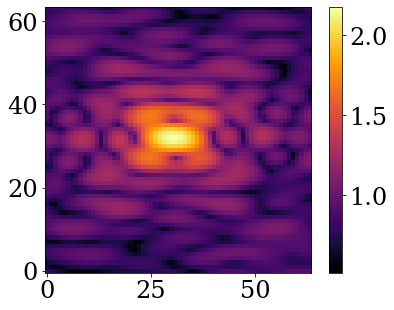

In [4]:
plt.imshow(exposures[0].data**0.125)
plt.colorbar()
np.sum(exposures[0].data)

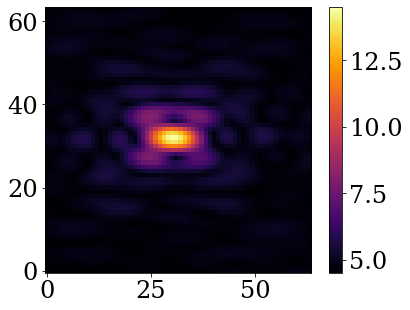

In [5]:
plt.imshow(exposures[0].err)
plt.colorbar()

In [6]:
params = {
    "fluxes": {},
    "positions": {},
    "aberrations": {},#np.zeros(8),#np.asarray([0,18,19.4,-1.4,-3,3.3,1.7,-12.2])*1e-9,
    "cold_mask_shift": {}, #np.asarray([-0.05, -0.05]),
    "cold_mask_rot": {},#np.asarray([np.pi/4]),
    "outer_radius": 1.2*0.955,
    "secondary_radius": 0.372*1.2,
    "spider_width": 0.077*1.2,
}

for exp in exposures:
    params["positions"][exp.fit.get_key(exp, "positions")] = np.asarray([0.,0.])
    params["fluxes"][exp.fit.get_key(exp, "fluxes")] = np.nansum(exp.data)
    #params["aberrations"] = injected_params["aberrations"]
    params["aberrations"][exp.fit.get_key(exp, "aberrations")] = np.zeros(8)#jr.uniform(jr.key(0), (8,),minval=-2e-8, maxval=2e-8)#np.zeros(8)#np.ones(8)*1e-8
    params["cold_mask_shift"][exp.fit.get_key(exp, "cold_mask_shift")] = np.asarray([-0.07,-0.07])
    params["cold_mask_rot"][exp.fit.get_key(exp, "cold_mask_rot")] = np.pi/4

params = ModelParams(params)

In [7]:
print(params.params)

{'fluxes': {'injected_F190N': Array(27414.41906429, dtype=float64)}, 'positions': {'injected_F190N': Array([0., 0.], dtype=float64)}, 'aberrations': {'injected_F190N': Array([0., 0., 0., 0., 0., 0., 0., 0.], dtype=float64)}, 'cold_mask_shift': {'injected_F190N': Array([-0.07, -0.07], dtype=float64)}, 'cold_mask_rot': {'injected_F190N': 0.7853981633974483}, 'outer_radius': 1.146, 'secondary_radius': 0.44639999999999996, 'spider_width': 0.0924}


In [8]:
def scheduler(lr, start, *args):
    shed_dict = {start: 1e10}
    for start, mul in args:
        shed_dict[start] = mul
    return optax.piecewise_constant_schedule(lr / 1e10, shed_dict)

base_sgd = lambda vals: optax.sgd(vals, nesterov=True, momentum=0.6)

opt = lambda lr, start, *schedule: base_sgd(scheduler(lr, start, *schedule))

base_adam = lambda vals: optax.adam(vals)
opta = lambda lr, start, *schedule: base_adam(scheduler(lr, start, *schedule))


def flatten(l):
    if isinstance(l, (tuple, list)):
         return [a for i in l for a in flatten(i)]
    else:
        return [l]

g = 1e-2

things = {
    "fluxes" : opt(g*20,10),
    "positions": opt(g*10, 0),
    #"cold_mask_shift": opt(g*3, 20),
    #"cold_mask_rot": opt(g*100, 100),
    "aberrations": opt(g*3,25),
    #"outer_radius": opt(g*200, 130),
    #"secondary_radius": opt(g*100,130),
    #"spider_width": opt(g*200,130),
}

groups = list(things.keys())
paths = flatten(groups)
optimisers = [things[i] for i in groups]
groups = [list(x) if isinstance(x, tuple) else x for x in groups]

In [9]:
@zdx.filter_jit
@zdx.filter_value_and_grad(paths)
def loss_fn(params,exposures):
    mdl = params.inject(model)
    return np.nansum(np.asarray([posterior(mdl,exposure) for exposure in exposures]))


In [10]:
rc = True
fishers = calc_fishers(model, exposures, paths, recalculate=rc)
lrs = calc_lrs(model, exposures, fishers, paths)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

In [11]:
optim, opt_state = zdx.get_optimiser(
    params, groups, optimisers
)


losses, models = [], []
for i in tqdm(range(150)):        
    loss, grads = loss_fn(params,exposures)
    grads = jtu.tree_map(lambda x, y: x * np.abs(y), grads, ModelParams(lrs.params))
    updates, opt_state = optim.update(grads, opt_state)
    params = zdx.apply_updates(params, updates)

    models.append(params)
    losses.append(loss)


  0%|          | 0/150 [00:00<?, ?it/s]

In [12]:
params.params

{'aberrations': {'injected_F190N': Array([ 1.29625990e-08, -4.98885976e-10, -1.38216113e-09, -3.09524727e-08,
          1.34636824e-08,  1.04819301e-08, -3.84647483e-09,  1.45059554e-08],      dtype=float64)},
 'cold_mask_rot': {'injected_F190N': 0.7853981633974483},
 'cold_mask_shift': {'injected_F190N': Array([-0.07, -0.07], dtype=float64)},
 'fluxes': {'injected_F190N': Array(30027.22956582, dtype=float64)},
 'outer_radius': 1.146,
 'positions': {'injected_F190N': Array([-2.83933997e-07,  8.78765813e-08], dtype=float64)},
 'secondary_radius': 0.44639999999999996,
 'spider_width': 0.0924}

3
30000
0
[-3.e-07  1.e-07]
1
[-8.59023084e-10  1.77049982e-09 -4.45293089e-09 -3.70890613e-08
  2.03658617e-08  1.08092528e-08 -2.77077727e-09  1.86458672e-09]
1


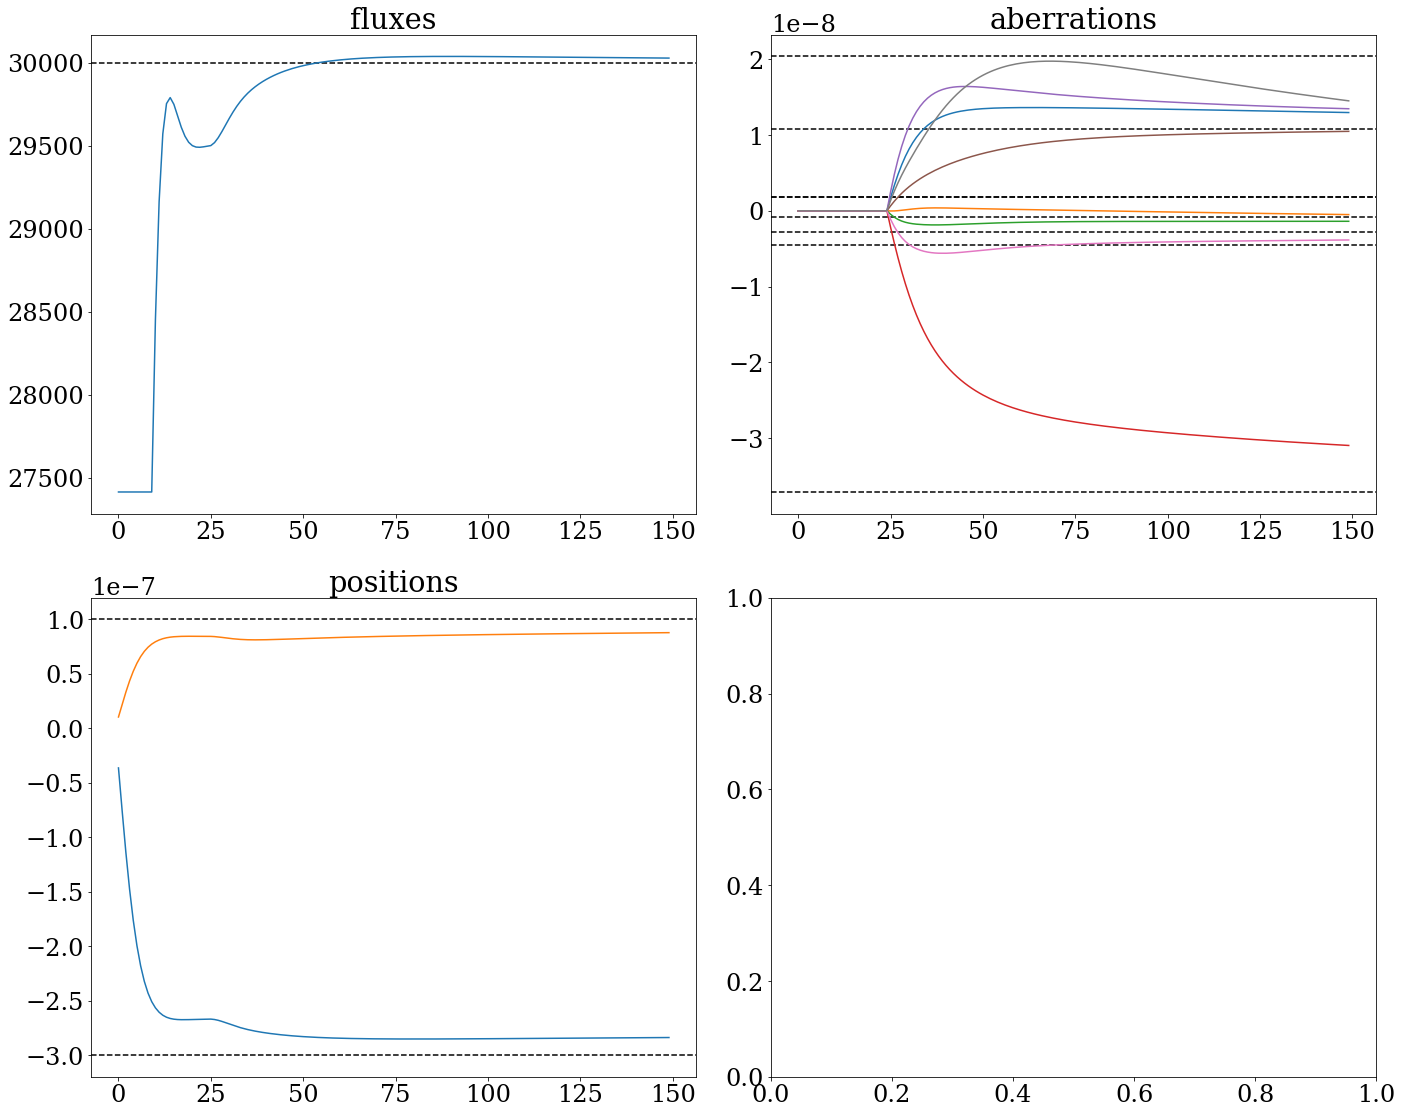

In [13]:
xw = 2
yw = int(np.ceil(len(groups)/xw))

print(len(groups))


fig, axs = plt.subplots(xw,yw,figsize=(xw*10,yw*8))
for i, param in enumerate(groups):
    #print(param)
    sp = axs[i%xw, i//xw]
    if param in ["fluxes", "contrast", "positions", "aberrations", "cold_mask_shift", "cold_mask_rot"]:
        #print(np.asarray(list(models_s[0].get(param).values())))
        #print(injected_params[param])
        for j in injected_params[param].values():
            print(j)
            print(len(j.shape))
            if len(j.shape)>0:
                for k in j:
                    sp.axhline(k, color='k', linestyle='--')
            else:
                sp.axhline(j, color='k', linestyle='--')
        for p in np.asarray([np.asarray(list(x.get(param).values())) for x in models]).T:
            if len(p.shape)>1:
                for i in range(p.shape[0]):
                    sp.plot(p[i,:])
            else:
                sp.plot(p)
            sp.set_title(param)
    else:
        sp.set_title(param)
        sp.plot([x.get(param) for x in models])
        sp.axhline(injected_params[param], color='k', linestyle='--')

    
fig.tight_layout()

1.272851e+04, 1.038048e+04


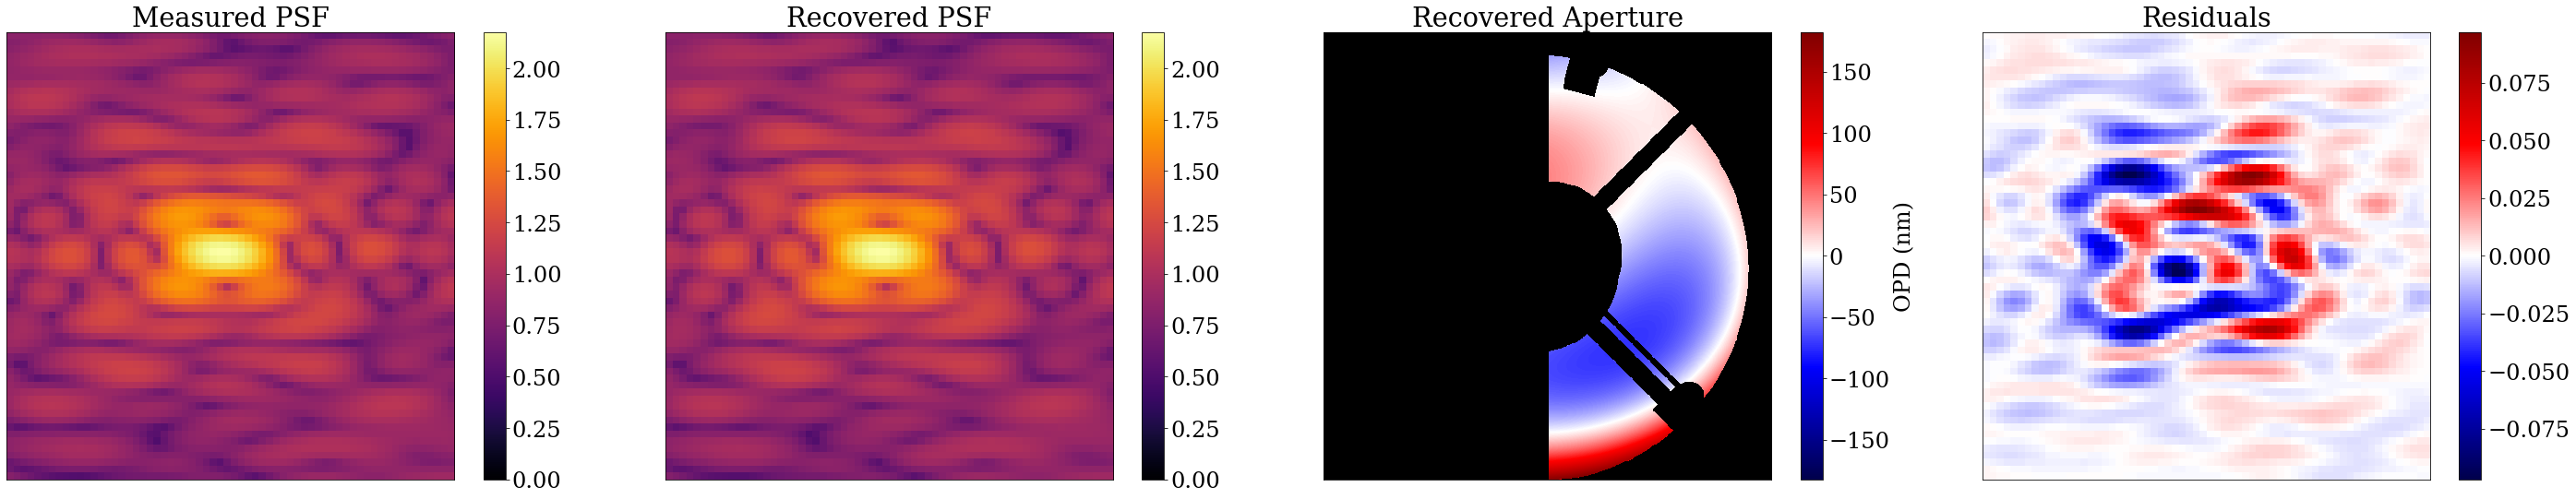

In [14]:
print(f"{float(losses[0]):e}, {float(losses[-1]):e}")

fig, axs = plt.subplots(1,4, figsize=(40,8))

fig.tight_layout()

cmap = matplotlib.colormaps['inferno']
cmap.set_bad('k',1)

#vm = max(np.max(cropped_data),np.max(telescope.model()))

exp = exposures[0]

model = params.inject(model)

coords = dlu.pixel_coords(512, 2.4)
cropped_frame = exp.data**0.125
telescope_frame = exp.fit(model,exp)**0.125

vm = max(np.nanmax(cropped_frame),np.nanmax(telescope_frame))
cd=axs[0].imshow(cropped_frame, vmin=0,vmax=vm,cmap=cmap)
plt.colorbar(cd,ax=axs[0])
tl=axs[1].imshow(telescope_frame, vmin=0, vmax=vm,cmap=cmap)
plt.colorbar(tl,ax=axs[1])
#axs[2].imshow(cropped_err)
cmap = matplotlib.colormaps['seismic']
cmap.set_bad('k',1)

optics = exp.fit.update_optics(model, exp)

support = optics.transmission(coords,2.4/512)
support_mask = support.at[support < .5].set(np.nan)

opd = optics.AberratedAperture.eval_basis(coords)*1e9
olim = np.max(np.abs(opd))
apt =axs[2].imshow(support_mask*opd,cmap=cmap,vmin=-olim, vmax=olim)
plt.colorbar(apt, ax=axs[2]).set_label("OPD (nm)")
#axs[4].imshow(telescope.detector.pixel_response.pixel_response)
resid = (exp.data - exp.fit(model,exp))/exp.err
rlim = np.nanmax(np.abs(resid))
resid=axs[3].imshow(resid, cmap='seismic',vmin=-rlim, vmax=rlim)
plt.colorbar(resid,ax=axs[3])

axs[0].set_title("Measured PSF")
axs[1].set_title("Recovered PSF")
axs[2].set_title("Recovered Aperture")
axs[3].set_title("Residuals")

for i in range(4):
    axs[i].set_xticks([])
    axs[i].set_yticks([])

#axs[1].imshow(telescope.optics.aberrations.eval_basis(coords)*1e9)
plt.show()
#plt.imshow(np.abs(telescope.model()-cropped_data)**0.25)


Text(0.5, 1.0, 'Injected Aberrations')

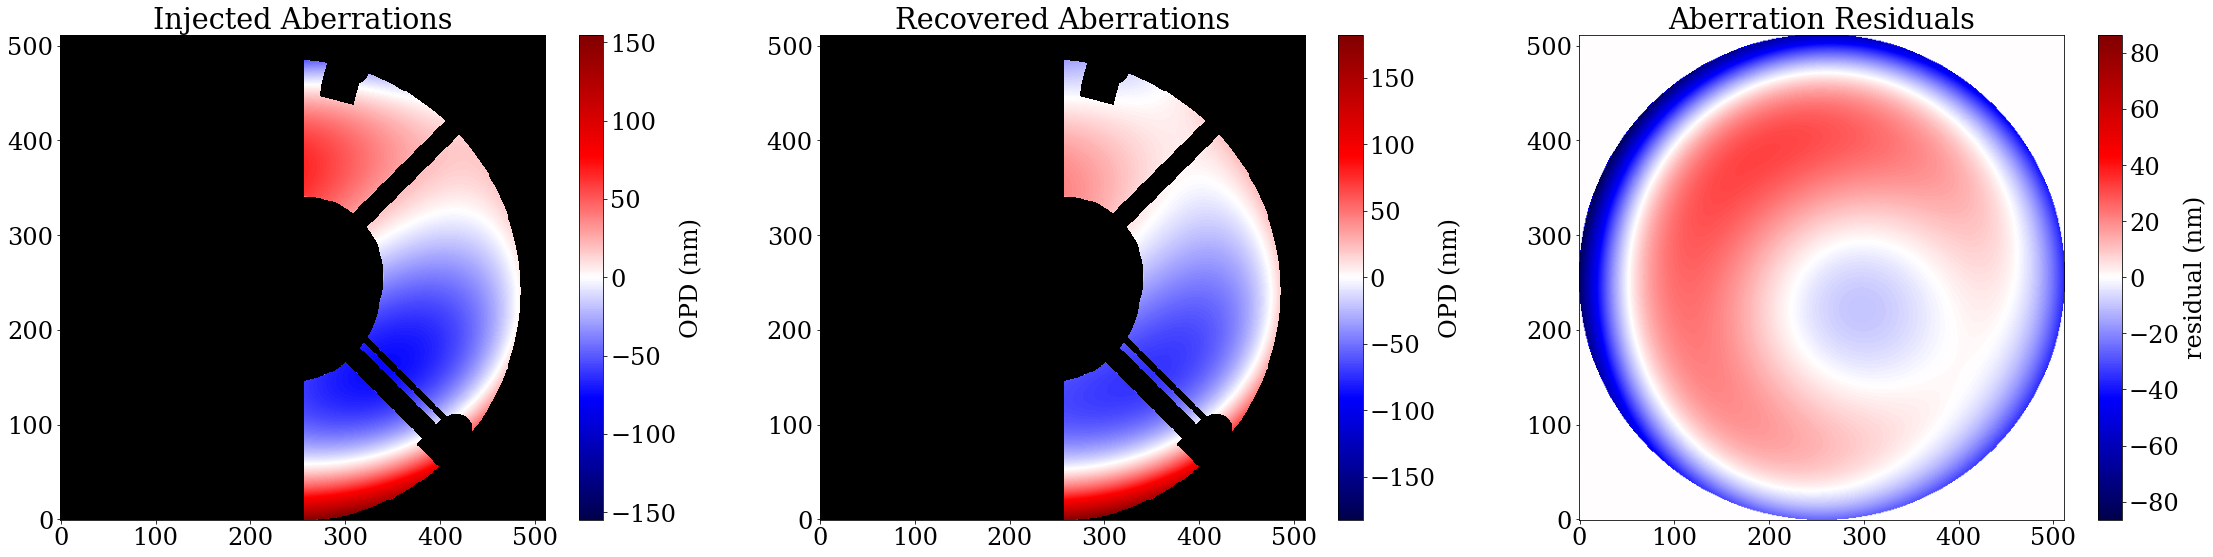

In [15]:
fig, axs = plt.subplots(1,3, figsize=(32,8))
fig.tight_layout()

cmap = matplotlib.colormaps['seismic']
cmap.set_bad('k',1)


model = ModelParams(injected_params).inject(model)
optics = exp.fit.update_optics(model, exp)

support = optics.transmission(coords,2.4/512)
support_mask = support.at[support < .5].set(np.nan)

opd_t = optics.AberratedAperture.eval_basis(coords)*1e9
olim = np.max(np.abs(opd_t))
apt =axs[0].imshow(support_mask*opd_t,cmap=cmap,vmin=-olim, vmax=olim)
plt.colorbar(apt, ax=axs[0]).set_label("OPD (nm)")

model = params.inject(model)
optics = exp.fit.update_optics(model, exp)

support = optics.transmission(coords,2.4/512)
support_mask = support.at[support < .5].set(np.nan)

opd_r = optics.AberratedAperture.eval_basis(coords)*1e9
olim = np.max(np.abs(opd_r))
apt =axs[1].imshow(support_mask*opd_r,cmap=cmap,vmin=-olim, vmax=olim)
plt.colorbar(apt, ax=axs[1]).set_label("OPD (nm)")

resid = opd_t - opd_r
olim = np.max(np.abs(resid))
apt =axs[2].imshow(resid,cmap=cmap,vmin=-olim, vmax=olim)
plt.colorbar(apt, ax=axs[2]).set_label("residual (nm)")
axs[2].set_title("Aberration Residuals")
axs[1].set_title("Recovered Aberrations")
axs[0].set_title("Injected Aberrations")




In [16]:
params.params

{'aberrations': {'injected_F190N': Array([ 1.29625990e-08, -4.98885976e-10, -1.38216113e-09, -3.09524727e-08,
          1.34636824e-08,  1.04819301e-08, -3.84647483e-09,  1.45059554e-08],      dtype=float64)},
 'cold_mask_rot': {'injected_F190N': 0.7853981633974483},
 'cold_mask_shift': {'injected_F190N': Array([-0.07, -0.07], dtype=float64)},
 'fluxes': {'injected_F190N': Array(30027.22956582, dtype=float64)},
 'outer_radius': 1.146,
 'positions': {'injected_F190N': Array([-2.83933997e-07,  8.78765813e-08], dtype=float64)},
 'secondary_radius': 0.44639999999999996,
 'spider_width': 0.0924}